In [7]:
###################################################################
######## NEURAL NETWORK FOR IMAGE CLASSIFICATION ##################
###################################################################


##Script that implements and trains a two-layered NN for the detection of breast 
##cancer tumors (image classification)
import os
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_addons as tfa
#!pip install tensorflow_addons
from sklearn.metrics import *
#import scikitplot as skplt
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
from functools import partial
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
#Download into COLAB and unzip the data
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1G7nnjrMvbWw-JARjG11xR8X84Z0HiGCF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1G7nnjrMvbWw-JARjG11xR8X84Z0HiGCF" -O FILENAME && rm -rf /tmp/cookies.txt
#!unzip /content/FILENAME


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data = pd.read_csv('./project3/data/Folds.csv')
data = data.loc[data['mag'] == 400]
#img_dir = './data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
img_dir = './project3/data/BreaKHis_v1/'
class_names = ['benign', 'malignant']
data = data.rename(columns={'filename':'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])
data.head(3)

fold  mag    grp                                               path  \
91     1  400  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
92     1  400  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
93     1  400  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

     label  label_int                        filename  
91  benign          0  SOB_B_A-14-22549AB-400-001.png  
92  benign          0  SOB_B_A-14-22549AB-400-002.png  
93  benign          0  SOB_B_A-14-22549AB-400-003.png

Count of Benign    :  2940
Count of Malignant :  6160


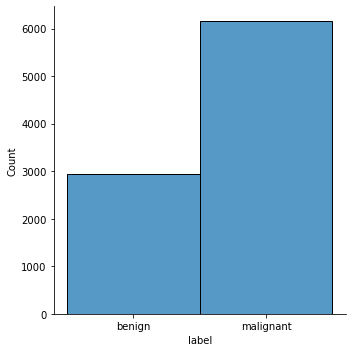

In [10]:
ax = sns.displot(data=data, x='label')
print('Count of Benign    : ', data[data.label == 'benign'].label.count())
print('Count of Malignant : ', data[data.label == 'malignant'].label.count())

In [11]:

# remove 600 from dataset for testing
test_df = data.groupby('label').sample(n=300)
train_df = data.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# split training and validation set
valid_df = train_df.sample(frac=0.2)
train_df = train_df.drop(valid_df.index).reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

test_df['set'] = 'test'
train_df['set'] = 'train'
valid_df['set'] = 'valid'
data_new = pd.concat([train_df,valid_df, test_df])

###upsample training set cus it was a little unbalanced
max_count = np.max(train_df.label.value_counts())
min_count = np.min(train_df.label.value_counts())
train_df = train_df.groupby('label').sample(n=max_count, replace=True)
train_df = train_df.reset_index(drop=True)
train_df.label.value_counts()

ax = sns.displot(data=train_df, x='label')

In [70]:
test_df

fold  mag    grp                                               path  \
0       3  400  train  BreaKHis_v1/histology_slides/breast/malignant/...   
1       2  400  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2       1  400  train  BreaKHis_v1/histology_slides/breast/malignant/...   
3       3  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
4       4  400   test  BreaKHis_v1/histology_slides/breast/benign/SOB...   
..    ...  ...    ...                                                ...   
595     1  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
596     2  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
597     4  400  train  BreaKHis_v1/histology_slides/breast/malignant/...   
598     4  400  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
599     5  400  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

         label  label_int                         filename   set  
0    malignant          1     SOB_M_DC-14-4372-400-009.png  test  
1       benign          0      SOB_B_F-14-9133-400-005.png  test  
2    malignant          1    SOB_M_DC-14-16601-400-003.png  test  
3    malignant          1    SOB_M_MC-14-19979-400-023.png  test  
4       benign          0    SOB_B_PT-14-22704-400-030.png  test  
..         ...        ...                              ...   ...  
595  malignant          1    SOB_M_DC-14-11520-400-004.png  test  
596  malignant          1     SOB_M_DC-14-2985-400-003.png  test  
597  malignant          1     SOB_M_DC-14-5695-400-004.png  test  
598     benign          0     SOB_B_F-14-14134-400-037.png  test  
599     benign          0  SOB_B_PT-14-29315EF-400-015.png  test  

[600 rows x 8 columns]

In [12]:
# Define helpers

def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])/255
    return img, label

def aug_fn(image): 
    transforms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(p=0.5, limit=15),
        A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.1, 0.1)),
        A.RandomResizedCrop(p=0.8, height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.9, 1.1), ratio=(0.05, 1.1), interpolation=0),
        A.Blur(p=0.3, blur_limit=(1, 1)),
    ])
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, [IMAGE_SIZE, IMAGE_SIZE])/255
    return aug_img

def augmentor(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img, label

def view_image(ds, col=8, row=2, size=(25,7)):
    plt.figure(figsize=size)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    for images, labels in ds.take(1):
        for i in range(col*row):
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off") 
    plt.tight_layout
    return None

def training_history(history):
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(len(history['loss']))

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
    return None

def decode_test(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224, 224])/255
    return img

def build_network(image_size):
    print('building model...')
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(image_size, image_size, 3)),
        hub.KerasLayer(model_handle, trainable=True, name='base_model'),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid', name='classifier') 
    ],name=model_name)
    model.build((None, image_size, image_size, 3))
    model.summary()
    print('model loaded!!!')
    return model

def view_prediction():
    plt.figure(figsize=(25,8))
    plt.rcParams.update({'font.size': 8})
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    for i in range(30):
        ax = plt.subplot(3, 10, i + 1)
        shape = str(test_img[i].numpy().shape)
        plt.imshow(test_img[i].numpy())
        plt.title(pred_label[i][0])
        plt.axis("off") 
        plt.tight_layout
    return None 

def view_wrong_prediction(df):
    plt.figure(figsize=(len(df)*4,8))
    plt.rcParams.update({'font.size': 8})
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    for i in range(len(df)):
        img = decode_test(img_dir+df.path.iloc[i])
        ax = plt.subplot(1, len(df), i + 1)
        plt.imshow(img)
        plt.title('wrongly predicted as '+df.prediction.iloc[i])
        plt.axis("off") 
        plt.tight_layout
    return None

IMAGE_SIZE =  224
BATCH_SIZE = 64
EPOCHS = 12
SAMPLE_SIZE = len(train_df)

In [13]:
train_loader = tf.data.Dataset.from_tensor_slices((img_dir+train_df.path, train_df.label_int))
valid_loader = tf.data.Dataset.from_tensor_slices((img_dir+valid_df.path, valid_df.label_int))

train_ds = (
    train_loader.shuffle(len(train_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(partial(augmentor),num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE) 
)
valid_ds = (
    valid_loader.shuffle(len(valid_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

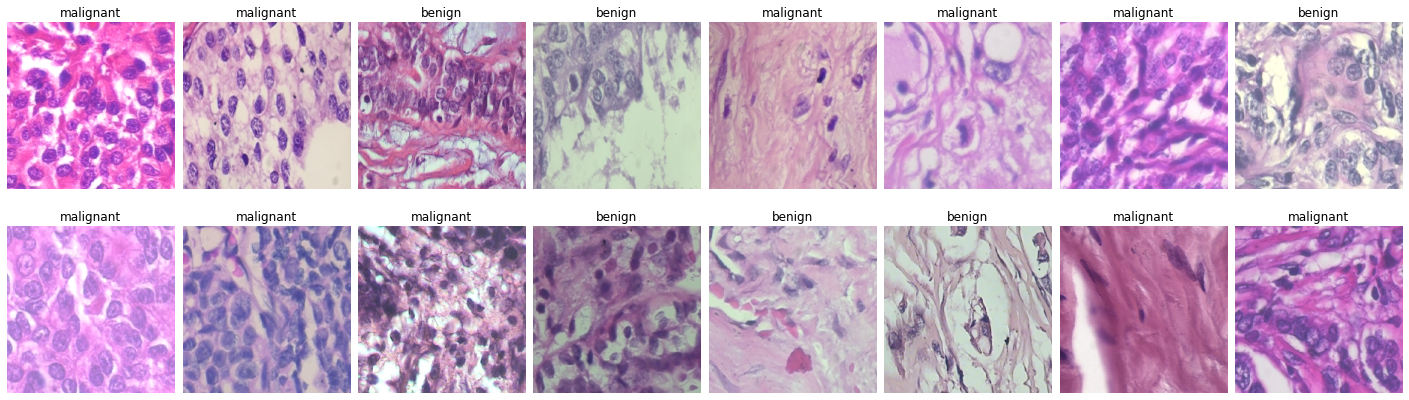

In [14]:
view_image(train_ds)

In [80]:
###Building the nn model
model = keras.models.Sequential([keras.layers.Flatten(input_shape = [224, 224, 3]),
keras.layers.Dense(300, activation = "relu" ),#hidden layer
keras.layers.Dense(100, activation = "relu"),#hidden layer
keras.layers.Dense(10, activation = "softmax"),
keras.layers.Dense(1, activation = 'sigmoid', name = 'classifier')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               45158700  
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
_________________________________________________________________
classifier (Dense)           (None, 1)                 11        
Total params: 45,189,821
Trainable params: 45,189,821
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
147/147 [==============================] - 38s 258ms/step - loss: 0.6872 - accuracy: 0.5462 - val_loss: 0.6568 - val_accuracy: 0.6035
Epoch 2/12
147/147 [==============================] - 42s 287ms/step - loss: 0.6287 - accuracy: 0.6630 - val_loss: 0.5270 - val_accuracy: 0.8171
Epoch 3/12
147/147 [==============================] - 57s 388ms/step - loss: 0.5839 - accuracy: 0.7335 - val_loss: 0.5184 - val_accuracy: 0.8106
Epoch 4/12
147/147 [==============================] - 46s 310ms/step - loss: 0.5620 - accuracy: 0.7531 - val_loss: 0.6960 - val_accuracy: 0.5976
Epoch 5/12
147/147 [==============================] - 46s 311ms/step - loss: 0.5532 - accuracy: 0.7600 - val_loss: 0.5361 - val_accuracy: 0.7735
Epoch 6/12
147/147 [==============================] - 48s 328ms/step - loss: 0.5447 - accuracy: 0.7645 - val_loss: 0.4620 - val_accuracy: 0.8653
Epoch 7/12
147/147 [==============================] - 46s 314ms/step - loss: 0.5343 - accuracy: 0.7695 - val_loss: 0.4554 - val_ac

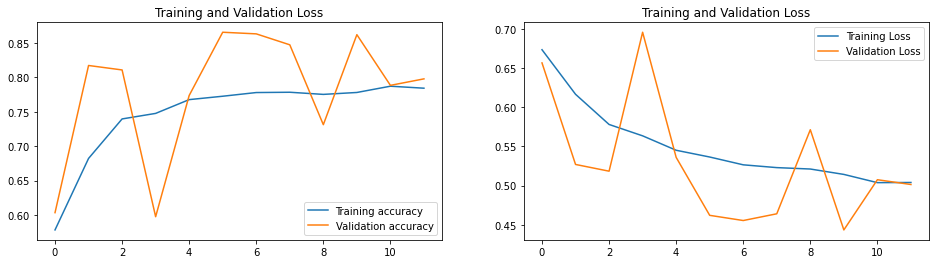

In [81]:
###Compile network
model.compile(loss = "binary_crossentropy",
optimizer = "sgd",
metrics = ["accuracy"])
###Train network

history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=valid_ds)

training_history(history.history)

              precision    recall  f1-score   support

      benign       0.82      0.79      0.80       300
   malignant       0.80      0.82      0.81       300

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

f1_score        : 0.8066666666666665
accuracy_score  : 0.8066666666666666


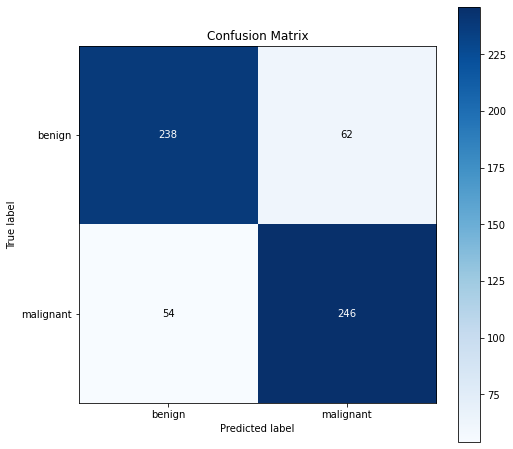

In [82]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_ds = tf.data.Dataset.from_tensor_slices(img_dir+test_df.path) 
test_ds = test_ds.map(decode_test,num_parallel_calls=AUTOTUNE).batch(len(test_df))
test_img = next(iter(test_ds))
test_index = test_df.label_int.values
test_label = test_df.label.values

test_pred = model.predict(test_ds)
pred_index = np.round(test_pred).astype('uint8')
pred_label = np.array(class_names)[pred_index]

print(classification_report(test_index, pred_index, target_names=class_names,zero_division=0))
print('f1_score        :', f1_score(test_index, pred_index, average='micro'))
print('accuracy_score  :', accuracy_score(test_index, pred_index))

cm = skplt.metrics.plot_confusion_matrix(test_label, pred_label, figsize=(8, 8), normalize=False)